In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calc_footprint_FFP_climatology as ffp
import cv2
from affine import Affine
import rasterio
import pyproj as proj

import os
from datetime import datetime

In [2]:
def write_img(f_2d, x_2d, y_2d,name):
    affine_transform = find_transform(x_2d, y_2d)
    # Create the GeoTiff file
    out_f = os.path.join(f'tiffs/{name}.tif')
    with rasterio.open(out_f, 'w', driver='GTiff', dtype=rasterio.float64,
                       height=f_2d.shape[0], width=f_2d.shape[1],
                       count=count, transform=affine_transform, crs=out_proj.srs,
                       nodata=0.00000000e+000) as new_dat:
        new_dat.write(f_2d, 1)
    new_dat.close()

def process_row(row):
    try:
        temp_ffp =  ffp.FFP_climatology(
        zm=row.zm - row.d,
        z0=row.z0,
        umean=row.u_mean,
        h=2000,
        ol=row.L,
        sigmav=row.sigma_v,
        ustar=row.u_star,
        wind_dir=row.wind_dir,
        fig=True,
        domain=[-origin_d,origin_d, -origin_d,origin_d],
        dx=dx,
        dy=dx,
        verbosity=1
        )
        f_2d = np.array(temp_ffp['fclim_2d'])
        x_2d = np.array(temp_ffp['x_2d']) + station_x
        y_2d = np.array(temp_ffp['y_2d']) + station_y
        mask = np.zeros_like(f_2d)
        mask[f_2d>temp_ffp['fr'][-2]] = 1
        plt.imshow(mask)
        # f_2d = f_2d*dx**2
        # At the beginning of your function, print the index of the row:
        # print(f"Processing row with index {row.name}")
        write_img(mask, x_2d, y_2d,row.name.date())
        # Rest of your processing code...        
    except Exception as e:
        print(f"Error processing row with index {row.name}")
        print(e)
        return None
    return f_2d, x_2d, y_2d




In [3]:

def find_transform(xs,ys):
    '''
    Returns the affine transform for 2d arrays xs and ys
    
    Args:
        xs (float) : 2D numpy array of x-coordinates
        ys (float) : 2D numpy array of y-coordinates
        
    Returns:
        aff_transform : affine.Affine object  
    '''
    
    shape = xs.shape

    #Choose points to calculate affine transform
    y_points = [0, 0, shape[0] - 1]
    x_points = [0, shape[0] - 1, shape[1] - 1]
    in_xy = np.float32([[i, j] for i, j in zip(x_points, y_points)])
    out_xy = np.float32([[xs[i, j], ys[i, j]] for i, j in zip(y_points, x_points)])
    

    #Calculate affine transform
    aff_transform = Affine(*cv2.getAffineTransform(in_xy,out_xy).flatten())

    return aff_transform

In [ ]:
data = pd.read_excel('/bess23/huaize/github/flux-data-footprint/example notebooks/crk_site/processed_data.xlsx', sheet_name='data',index_col=0,parse_dates=True)
data.columns
data = data.loc[:,['d','z0','u','L','v_unrot','ustar','WD(1)','hc']]

In [ ]:
dx=3
origin_d = 750.
station = 'crk'
count = 1

In [ ]:
daily = data.resample('D').mean()
monthly = daily.resample('M').mean()
monthly['sigma_v'] = daily['v_unrot'].resample('M').std()
monthly.rename(columns={'WD(1)':'wind_dir','hc':'h_canopy','u':'u_mean','ustar':'u_star'},inplace=True)
monthly

In [ ]:
latitude,longitude = 38.2013, 127.2505
station_coord = (longitude, latitude)

EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((183+longitude)/6.0)
EPSG = int(EPSG)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

In [ ]:
monthly  = monthly.dropna()

In [ ]:
# Process all rows and group by year
results = daily[daily.index.year<2021].apply(process_row, axis=1)
results = daily[daily.index.year==2021].apply(process_row, axis=1)
# results_grouped = results.groupby(results.index.year)

# 
# for year, group in results_grouped:
#     f_2d_avg = np.mean([item[0] for item in group if item is not None], axis=0)
#     x_2d_avg = np.mean([item[1] for item in group if item is not None], axis=0)
#     y_2d_avg = np.mean([item[2] for item in group if item is not None], axis=0)
#     # Calculate affine transform for given x_2d and y_2d
#     # Assuming find_transform is a function you have defined elsewhere

## Daily

In [4]:
data = pd.read_excel('/bess23/huaize/github/flux-data-footprint/example notebooks/crk_site/processed_data.xlsx', sheet_name='data',index_col=0,parse_dates=True)
data.columns
data = data.loc[:,['d','z0','u','L','v_unrot','ustar','WD(1)','hc']]

In [6]:
data['zm'] = 10


In [5]:
dx=3
origin_d = 750.
station = 'crk'
count = 1

In [7]:
daily = data.resample('D').mean()
daily['sigma_v'] = data['v_unrot'].resample('D').std()
daily.rename(columns={'WD(1)':'wind_dir','hc':'h_canopy','u':'u_mean','ustar':'u_star'},inplace=True)

In [8]:
latitude,longitude = 38.2013, 127.2505
station_coord = (longitude, latitude)

EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((183+longitude)/6.0)
EPSG = int(EPSG)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

/bess23/huaize/github/flux-data-footprint/.venv/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/bess23/huaize/github/flux-data-footprint/.venv/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_3521534/409687241.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-

In [9]:
daily  = daily.dropna()

/tmp/ipykernel_3521534/1510625512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['zm'] = 10
























Error processing row with index 2015-10-05 00:00:00
'>' not supported between instances of 'float' and 'NoneType'






Error processing row with index 2015-10-08 00:00:00
'>' not supported between instances of 'float' and 'NoneType'


Error processing row with index 2015-10-09 00:00:00
'>' not supported between instances of 'float' and 'NoneType'








Error processing row with index 2015-10-13 00:00:00
'>' not supported between instances of 'float' and 'NoneType'












Error processing row with index 2015-10-25 00:00:00
'>' not supported between instances of 'float' and 'NoneType'




Error processing row with index 2015-10-27 00:00:00
'>' not supported between instances of 'float' and 'NoneType'












Error processing row with index 2015-11-02 00:00:00
'>' not supported between instances of 'float' and 'NoneType'


Error processing row with index 2015-11-03 00:00:00
'>' not supported between instances of 'float' and 'NoneType'


Error processing r

/tmp/ipykernel_3521534/1510625512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['zm'] = 5












































































































































































































































































































































































































































































Error processing row with index 2021-08-17 00:00:00
'>' not supported between instances of 'float' and 'NoneType'






























































































































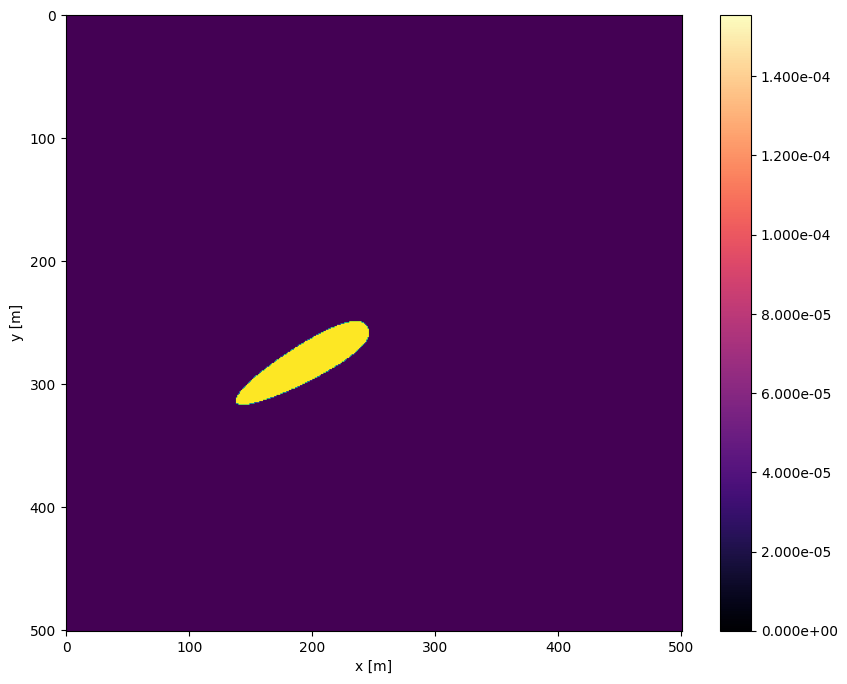

In [10]:
input = daily[daily.index.year<2021]
input['zm'] = 10
results = input.apply(process_row, axis=1)
input = daily[daily.index.year==2021]
input['zm'] = 5
results = input.apply(process_row, axis=1)

In [ ]:
tmp = daily.iloc[2,:].copy()
new_dat = None
date = str(tmp.name.date())
station = 'crk'
#Calculate footprint
temp_ffp =  ffp.FFP_climatology(
    zm=tmp.zm - tmp.d,
    z0=tmp.z0,
    umean=tmp.u_mean,
    h=2000,
    ol=tmp.L,
    sigmav=tmp.sigma_v,
    ustar=tmp.u_star,
    wind_dir=tmp.wind_dir,
    fig=True,
    domain=[-origin_d,origin_d,-origin_d,origin_d],
    dx=dx,
    dy=dx,
    # crop=True,
    verbosity=1
)


f_2d = np.array(temp_ffp['fclim_2d'])
x_2d = np.array(temp_ffp['x_2d']) + station_x
y_2d = np.array(temp_ffp['y_2d']) + station_y
f_2d = f_2d*dx**2

#Calculate affine transform for given x_2d and y_2d
affine_transform = find_transform(x_2d,y_2d)

#Create data file if not already created
if new_dat is None:
    out_f = os.path.join( f'{date}_{station}.tif')
    print(f_2d.shape)
    new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                            height=f_2d.shape[0],width=f_2d.shape[1],
                            count=1,
                            transform=affine_transform,
                            crs=out_proj.srs,
                            nodata=0.00000000e+000)

# except Exception as e:

# print(f'Hour {t} footprint failed, band {band} not written.')

# temp_ffp = None

# continue

#Mask out points that are below a % threshold (defaults to 90%)
# f_2d = ff.mask_fp_cutoff(f_2d)
indx=0
# #Write the new band
new_dat.write(f_2d,indx+1)
new_dat.close()
    
# #Update tags with metadata
# tag_dict = {'hour':f'{t*100:04}',
#         'wind_dir':temp_line['wd'].values,
#         'total_footprint':np.nansum(f_2d)}

# new_dat.update_tags(indx+1,**tag_dict)